## Testing scatnet features 
Author: Akash Kharita, ak287@uw.edu

In [161]:
import numpy as np
import pandas as pd
from glob import glob 
from tqdm import tqdm
import seaborn as sns 

# for converting the text file containing the quarry locations into csv file
import csv

# for computing the geographical distance between two points 
import math


from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from datetime import datetime
import h5py
from sklearn.preprocessing import LabelEncoder
from scipy import stats, signal
from sklearn.preprocessing import StandardScaler
import obspy
from obspy.geodetics.base import gps2dist_azimuth, gps2dist_azimuth
from obspy.clients.fdsn import Client
import time
pd.set_option('display.max_columns', None)
from joblib import dump, load
from obspy.signal.filter import envelope
import tsfel


import sys
sys.path.append('../feature_extraction_scripts/physical_feature_extraction_scripts')
sys.path.append('../src')
import seis_feature
#from seis_feature import compute_physical_features
from tsfel import time_series_features_extractor, get_features_by_domain
from datetime import timedelta
import os


from utils import apply_cosine_taper
from utils import butterworth_filter
from utils import plot_confusion_matrix
from utils import plot_classification_report

import pickle
from zenodo_get import zenodo_get

In [198]:
filename = 'P_10_30_F_1_10_50'

data_eq_1 = np.load('../extracted_features/scattering_coefficients_earthquake_'+filename+'_part_1.npz')
data_eq_2 = np.load('../extracted_features/scattering_coefficients_earthquake_'+filename+'_part_2.npz')
data_eq_3 = np.load('../extracted_features/scattering_coefficients_earthquake_'+filename+'_part_3.npz')
data_eq_4 = np.load('../extracted_features/scattering_coefficients_earthquake_'+filename+'_part_4.npz')


data_exp_1 = np.load('../extracted_features/scattering_coefficients_explosion_'+filename+'_part_1.npz')

data_su_1 = np.load('../extracted_features/scattering_coefficients_surface event_'+filename+'_part_1.npz')

data_no_1 = np.load('../extracted_features/scattering_coefficients_noise_'+filename+'_part_1.npz')

In [199]:
def extract_features_from_data(data, source):
    new_data_2 = np.reshape(data['order_2'], [len(data['order_2']), data['order_2'].shape[1]*data['order_2'].shape[2]])
    
    df1 = pd.DataFrame(data['order_1'])
    df1.columns = [f'order1_{col}' for col in df1.columns]
    
    df2 = pd.DataFrame(new_data_2)
    df2.columns = [f'order2_{col}' for col in df2.columns]
    
    df = pd.concat([df1, df2], axis = 1).applymap(np.log10)
    df['serial_no'] = data['serial_ids']
    df['source'] = [source]*len(data['order_1'])
    return df


In [200]:
features_su = extract_features_from_data(data_su_1, 'surface event')
features_exp = extract_features_from_data(data_exp_1, 'explosion')
features_no = extract_features_from_data(data_no_1, 'noise')

features_eq1 = extract_features_from_data(data_eq_1, 'earthquake')
features_eq2 = extract_features_from_data(data_eq_2, 'earthquake')
features_eq3 = extract_features_from_data(data_eq_3, 'earthquake')
features_eq4 = extract_features_from_data(data_eq_4, 'earthquake')

features_eq =  pd.concat([features_eq1, features_eq2, features_eq3, features_eq4])

/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/pandas/core/frame.py:8819: RuntimeWarning: divide by zero encountered in log10
  return lib.map_infer(x.astype(object)._values, func, ignore_na=ignore_na)


In [201]:
# extracting the stored data
comcat_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/comcat_waveforms.hdf5",'r')
exotic_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/exotic_waveforms.hdf5",'r')
noise_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/noise_waveforms.hdf5",'r')


# extracting the catalog
comcat_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")
exotic_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
noise_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")



# extracting the metadata corresponding to individual events
cat_exp = comcat_file_csv[comcat_file_csv['source_type'] == 'explosion']
cat_eq = comcat_file_csv[comcat_file_csv['source_type'] == 'earthquake']
cat_no = noise_file_csv
cat_su = exotic_file_csv[exotic_file_csv['source_type'] == 'surface event']



# extracting the index 
ind_exp = features_exp['serial_no'].values
ind_eq = features_eq['serial_no'].values
ind_no = features_no['serial_no'].values
ind_su = features_su['serial_no'].values


# explosion
exp_df = cat_exp.iloc[ind_exp]
exp_df.reset_index(drop = True, inplace = True)
exp_df['serial_no'] = ind_exp
features_exp['event_id'] = exp_df['event_id'].values
features_exp['new_event_id'] = exp_df['event_id']+'_'+exp_df['station_network_code']+'.'+exp_df['station_code']
features_exp['trace_start_time'] = exp_df['trace_start_time']

# earthquake
eq_df = cat_eq.iloc[ind_eq]
eq_df.reset_index(drop = True, inplace = True)
eq_df['serial_no'] = ind_eq
features_eq['event_id'] = eq_df['event_id']
features_eq['new_event_id'] = eq_df['event_id']+'_'+eq_df['station_network_code']+'.'+eq_df['station_code']
features_eq['trace_start_time'] = eq_df['trace_start_time']

# surface
su_df = cat_su.iloc[ind_su]
su_df.reset_index(drop = True, inplace = True)
su_df['serial_no'] = ind_su
features_su['event_id'] = su_df['event_id']
features_su['new_event_id'] = su_df['event_id']+'_'+su_df['station_network_code']+'.'+su_df['station_code']
features_su['trace_start_time'] = su_df['trace_start_time']

# noise
no_df = cat_no.iloc[ind_no]
no_df.reset_index(drop = True, inplace = True)
no_df['serial_no'] = ind_no
features_no['event_id'] = no_df['trace_start_time']+'_noise'
features_no['new_event_id'] = no_df['trace_start_time']+'_noise_'+no_df['station_network_code']+'.'+no_df['station_code']
features_no['trace_start_time'] = no_df['trace_start_time']


In [202]:
## first we would like to remove the common test dataset based on the ids
save_path = '../data'
common_test_ids = np.load(f"{save_path}/common_test_data_id.npy", allow_pickle = True)


In [203]:
data_new_su = np.load('../extracted_features/scattering_coefficients_new_surface_events_'+filename+'_part_1.npz')
features_new_su = extract_features_from_data(data_new_su, 'surface event')
features_new_su = features_new_su.rename(columns = {'serial_no':'new_event_id'})
# randomly assigning the event ids to surface events. 
features_new_su['serial_no'] = np.arange(len(features_new_su))
## trying to assign a date time. 
features_new_su['event_id'] = [features_new_su['new_event_id'].values[i].split('_')[0] for i in range(len(features_new_su))]

stored_su_df = pd.read_csv('../data/additional_surface_events_good_snr.csv')
event_trace_map = stored_su_df.set_index('event_id')['trace_start_time'].to_dict()

# Assign trace_start_time using map() instead of looping
features_new_su['trace_start_time'] = features_new_su['event_id'].map(event_trace_map)


# rearranging the order of the columns
features_new_su  = features_new_su.loc[:, features_new_su.columns]

## Merging all the features

In [204]:
features_all = pd.concat([features_su, features_no, features_exp, features_eq, features_new_su])
features_all = features_all.drop(['Unnamed: 0'], axis = 1, errors = 'ignore')
print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]-2} features')

So we have 250770 events and each event have 113 features


## Removing the test set from these events and saving

In [205]:
test_features = features_all[features_all['new_event_id'].isin(common_test_ids)]
test_features.to_csv('../data/test_scatnet_features_'+filename+'.csv', index = False)

In [206]:
train_features = features_all[~features_all['new_event_id'].isin(common_test_ids)]
train_features

,order1_0,order1_1,order1_2,order1_3,order1_4,order1_5,order1_6,order1_7,order1_8,order1_9,order2_0,order2_1,order2_2,order2_3,order2_4,order2_5,order2_6,order2_7,order2_8,order2_9,order2_10,order2_11,order2_12,order2_13,order2_14,order2_15,order2_16,order2_17,order2_18,order2_19,order2_20,order2_21,order2_22,order2_23,order2_24,order2_25,order2_26,order2_27,order2_28,order2_29,order2_30,order2_31,order2_32,order2_33,order2_34,order2_35,order2_36,order2_37,order2_38,order2_39,order2_40,order2_41,order2_42,order2_43,order2_44,order2_45,order2_46,order2_47,order2_48,order2_49,order2_50,order2_51,order2_52,order2_53,order2_54,order2_55,order2_56,order2_57,order2_58,order2_59,order2_60,order2_61,order2_62,order2_63,order2_64,order2_65,order2_66,order2_67,order2_68,order2_69,order2_70,order2_71,order2_72,order2_73,order2_74,order2_75,order2_76,order2_77,order2_78,order2_79,order2_80,order2_81,order2_82,order2_83,order2_84,order2_85,order2_86,order2_87,order2_88,order2_89,order2_90,order2_91,order2_92,order2_93,order2_94,order2_95,order2_96,order2_97,order2_98,order2_99,serial_no,source,event_id,new_event_id,trace_start_time
0,-1.779082,-0.938503,-0.180336,0.369210,0.707187,0.922731,0.806584,0.672105,0.609764,0.086796,-2.936024,-2.535497,-2.187615,-1.678863,-1.290402,-1.018795,-1.146996,-1.036689,-0.734611,-0.614038,-2.157227,-1.810537,-1.490686,-0.984070,-0.496968,-0.212833,-0.222275,-0.174476,0.140389,0.256234,-1.567966,-1.237168,-0.870536,-0.461450,0.120244,0.498613,0.559455,0.578077,0.962073,1.047717,-1.293761,-0.914986,-0.580818,-0.237403,0.300952,0.792964,0.972151,1.050843,1.388747,1.607621,-1.532826,-1.051916,-0.494314,-0.017185,0.509808,0.875931,1.416716,1.235481,1.692404,1.825294,-1.555361,-1.150174,-0.776998,-0.430310,-0.096007,0.328910,0.911665,1.240332,1.751460,2.123585,-1.809356,-1.413422,-1.077759,-0.756113,-0.382038,-0.015898,0.541800,0.991370,1.615315,1.760612,-1.773304,-1.396787,-1.041457,-0.705335,-0.382719,-0.048630,0.263936,0.761219,1.277845,1.839070,-2.261398,-1.864479,-1.509405,-1.134819,-0.787534,-0.457556,-0.138002,0.176499,0.499391,0.905397,-12.232805,-11.094812,-8.116415,-5.862129,-4.159784,-2.866354,-1.870639,-1.092031,-0.452447,0.093177,0,surface event,pnsn3179368,pnsn3179368_UW.RCM,2021-12-22T04:49:15.000000Z
1,-1.223146,-0.379120,0.280198,0.623818,0.844753,0.678328,0.587260,0.708274,0.654588,0.219438,-2.649050,-2.023907,-1.523169,-1.137045,-0.884038,-0.582299,-0.386087,-0.539072,-0.299510,-0.233642,-1.702959,-1.335893,-0.870159,-0.462871,-0.228750,0.257325,0.469572,0.358222,0.583677,0.630096,-1.366158,-0.990248,-0.572740,-0.167230,0.153951,0.756420,1.169718,1.142443,1.185348,1.182480,-0.852758,-0.443730,-0.127040,0.131374,0.599128,0.924494,1.508510,1.707013,1.262956,1.522856,-1.252755,-0.757221,-0.332595,0.050754,0.440368,0.834457,1.228953,1.711908,1.841879,1.733791,-1.842464,-1.446359,-1.081681,-0.672971,-0.047303,0.322895,1.140688,1.310129,1.373272,1.791292,-2.399985,-1.749224,-1.208645,-0.747697,-0.340446,0.027870,0.362728,0.770312,1.289257,1.749635,-1.919392,-1.642785,-1.347159,-1.048291,-0.748972,-0.450270,-0.040818,0.370022,1.017196,1.267710,-2.873182,-2.636005,-2.360274,-2.070534,-1.745762,-1.369786,-0.952189,-0.570284,-0.216664,0.276132,-9.051196,-6.998897,-5.447495,-4.264909,-3.349630,-2.625621,-1.996112,-1.342811,-0.798788,-0.334609,1,surface event,pnsn3179093,pnsn3179093_CC.VALT,2021-12-19T07:32:46.000000Z
2,-1.260717,-0.405147,0.207491,0.514800,0.765401,0.855495,0.612765,0.725894,0.697363,0.256844,-2.562647,-2.185920,-1.904614,-1.231003,-0.910261,-0.614303,-0.717209,-0.327639,-0.337872,-0.211157,-1.616166,-1.297575,-1.099495,-0.467361,-0.160082,0.209518,0.050205,0.568742,0.596586,0.662337,-1.491663,-1.095184,-0.689838,-0.165364,0.377759,0.933367,0.755816,1.252539,1.063094,1.166024,-0.875806,-0.461495,-0.173869,0.204325,0.679690,1.067132,1.291121,1.409656,1.703223,1.618696,-1.077121,-0.704196,-0.361154,-0.035360,0.402556,0.836821,1.594601,1.670764,1.924879,2.182509,-1.414517,-1.062496,-0.5894

## Adding the manual features

In [207]:
# new_exp contains the features and the corresponding metadata information. 
datetimes = train_features['trace_start_time'].values

hour_of_day = []
days_of_week = []
month_of_year = []
for dt_str in tqdm(datetimes):
        
    # Parse the datetime string
        dt = datetime.strptime(dt_str, '%Y-%m-%dT%H:%M:%S.%fZ')
        hod = dt.hour - 8.  # converting to local time. 
        moy = dt.month
        
        
        days_of_week.append(dt.weekday())
        hour_of_day.append(hod)
        month_of_year.append(moy)
        
train_features['hour_of_day'] = hour_of_day
train_features['day_of_week'] = days_of_week
train_features['month_of_year'] = month_of_year


100%|██████████| 243026/243026 [00:02<00:00, 116046.07it/s]
/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


## Preprocessing the input features

## Removing highly correlated features

In [208]:
# Identify columns with NaN values

features_all = train_features.copy()
nan_columns = features_all.columns[features_all.isnull().any()].tolist()
print("Columns with NaN values:", nan_columns)

# Identify columns with infinity values
inf_columns = features_all.columns[(features_all == np.inf).any() | (features_all == -np.inf).any()].tolist()
print("Columns with infinity values:", inf_columns)

# Dropping the columns that contain NaNs
features_all = features_all.dropna(axis=1)

# Dropping the rows that contain NaNs
features_all = features_all.dropna()

# Dropping all the rows containing infinity values
features_all = features_all.replace([np.inf, -np.inf], np.nan).dropna()

# Dropping sonic boom and thunder events
features_all = features_all[features_all['source'] != 'sonic']
features_all = features_all[features_all['source'] != 'thunder']

print(f'So we have {features_all.shape[0]} events and each event has {features_all.shape[1]} features')

Columns with NaN values: []
Columns with infinity values: ['order1_0', 'order1_1', 'order1_2', 'order1_3', 'order1_4', 'order1_5', 'order1_6', 'order1_7', 'order1_8', 'order1_9', 'order2_0', 'order2_1', 'order2_2', 'order2_3', 'order2_4', 'order2_5', 'order2_6', 'order2_7', 'order2_8', 'order2_9', 'order2_10', 'order2_11', 'order2_12', 'order2_13', 'order2_14', 'order2_15', 'order2_16', 'order2_17', 'order2_18', 'order2_19', 'order2_20', 'order2_21', 'order2_22', 'order2_23', 'order2_24', 'order2_25', 'order2_26', 'order2_27', 'order2_28', 'order2_29', 'order2_30', 'order2_31', 'order2_32', 'order2_33', 'order2_34', 'order2_35', 'order2_36', 'order2_37', 'order2_38', 'order2_39', 'order2_40', 'order2_41', 'order2_42', 'order2_43', 'order2_44', 'order2_45', 'order2_46', 'order2_47', 'order2_48', 'order2_49', 'order2_50', 'order2_51', 'order2_52', 'order2_53', 'order2_54', 'order2_55', 'order2_56', 'order2_57', 'order2_58', 'order2_59', 'order2_60', 'order2_61', 'order2_62', 'order2_63',

In [209]:
# Check unique values in each column
unique_counts = features_all.nunique()

# Identify columns with only one unique value (same value for all rows)
single_value_columns = unique_counts[unique_counts == 1].index.values

print(single_value_columns)

# Drop columns with the same value for all rows
features_all = features_all.drop(columns=single_value_columns)

print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')


[]
So we have 239323 events and each event have 118 features


In [210]:
df = features_all.drop(['serial_no', 'source','event_id','new_event_id','trace_start_time'], axis = 1)
# Calculate Z-scores for each feature
z_scores = np.abs(stats.zscore(df))


# Define a threshold for Z-score beyond which data points are considered outliers
threshold = 10

# Filter out rows with any Z-score greater than the threshold
# Temporarily removing this 
outliers_removed_df =   features_all[(z_scores < threshold).all(axis=1)]

print(f'So we have {outliers_removed_df.shape[0]} events and each event have {outliers_removed_df.shape[1]} features')


So we have 239199 events and each event have 118 features


In [211]:
## defining the global variables X and y
X = outliers_removed_df.drop(['serial_no','source','event_id','new_event_id','trace_start_time'], axis = 1)
y = outliers_removed_df['source']


# Initialize the StandardScaler
scaler = StandardScaler()



# Apply standard scaling to the DataFrame
scaled_features = scaler.fit_transform(X)


# Access the mean and standard deviation for each feature
means = scaler.mean_
std_devs = scaler.scale_

# Create a DataFrame to display the means and standard deviations
scaler_params = pd.DataFrame({'Feature': X.columns, 'Mean': means, 'Std Dev': std_devs})
print(scaler_params)


# Create a new DataFrame with scaled features
X_scaled = pd.DataFrame(scaled_features, columns=X.columns)


## We are not standardizing at this stage. We will rather wait when the outlier are removed, then we will
## standardize and save the standard scaler parameters. 
#X_scaled = X

X_scaled['serial_no'] = outliers_removed_df['serial_no'].values
X_scaled['source'] = outliers_removed_df['source'].values
X_scaled['new_event_id'] = outliers_removed_df['new_event_id'].values

           Feature      Mean   Std Dev
0         order1_0 -1.006846  0.252510
1         order1_1 -0.229312  0.239425
2         order1_2  0.299904  0.199186
3         order1_3  0.519280  0.144071
4         order1_4  0.582600  0.146408
..             ...       ...       ...
108      order2_98 -0.454182  0.597985
109      order2_99 -0.040218  0.568910
110    hour_of_day  3.792629  7.018609
111    day_of_week  2.985690  1.977125
112  month_of_year  6.694413  3.225873

[113 rows x 3 columns]


## Hyperparameter tuning

In [212]:
temp_X = X_scaled.drop(['serial_no','source','new_event_id'], axis = 1)
y = X_scaled['source'].values

# Apply random undersampling using imbalanced-learn library
rus = RandomUnderSampler(sampling_strategy={'earthquake':3000, 'explosion':3000, 'surface event':3000, 'noise':3000})
X_resampled, y_resampled = rus.fit_resample(temp_X, y)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the LabelEncoder on the text labels and transform them to numeric labels
y_num = label_encoder.fit_transform(y_resampled)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_num, test_size=0.2, stratify = y_num)



# Define the hyperparameter grid for randomized search
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Initialize the RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist, n_iter=50, scoring='f1_macro', cv=10, verbose=0, random_state=42, n_jobs=-1
)

# Perform randomized grid search cross-validation
random_search.fit(X_train, y_train)

# Print the best parameters and their corresponding accuracy score
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = np.sum(y_pred == y_test) / len(y_test)
print("Test Accuracy:", accuracy)




Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': False}
Best Accuracy: 0.7258975437152937
Test Accuracy: 0.73375


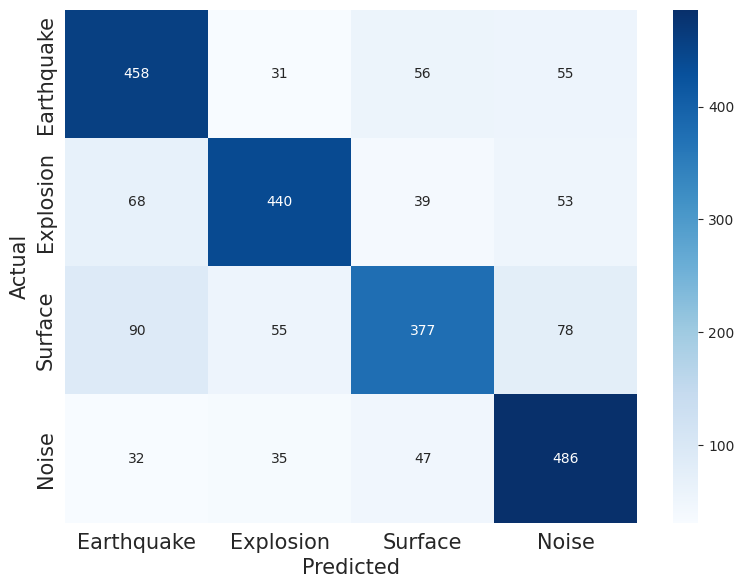

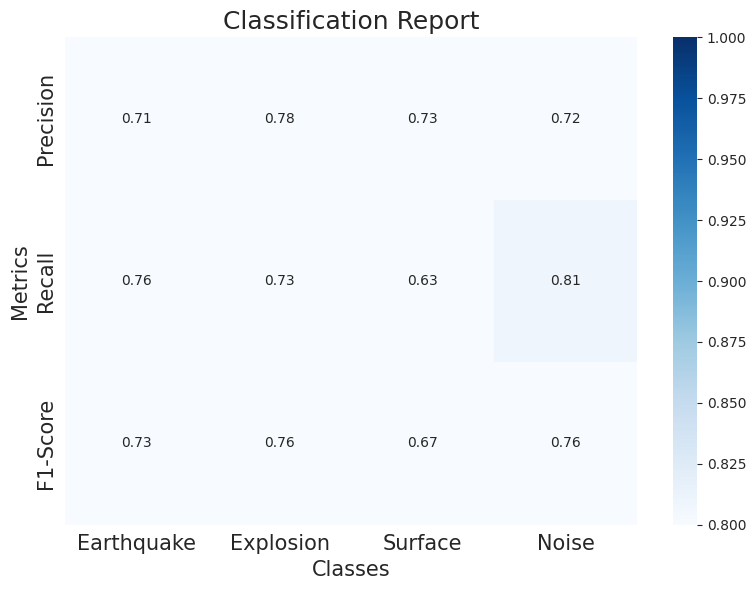

In [213]:
## plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, figure_name = '../figures/confusion_matrix_hyp_tuning_scat_'+filename+'.png')


# Calculate the classification report
report = classification_report(y_test, y_pred, output_dict=True)
plot_classification_report(report, figure_name = '../figures/classification_report_hyp_tuning_scat_'+filename+'.png')


## Preparing the training and validation sets

In [214]:
## extracting metadata information for each kind of source along with features
## source_type_pnsn_label is more reliable label. 


# selecting all the earthquakes and their metadata information. 
a_eq = X_scaled[X_scaled['source'] == 'earthquake']

## removing the ambiguous events, these are the events that were assigned as earthquakes by pnsn but labelled as
## explosion in USGS ANSS catalog. 
a_eq = a_eq[a_eq['source'] != 'explosion']


## selecting all the explosions specifically px, (which is mainly quarry blasts)
a_px = X_scaled[X_scaled['source'] == 'explosion']
# removing the ambiguous events. 
a_px = a_px[a_px['source'] != 'earthquake']

a_su = X_scaled[X_scaled['source'] == 'surface event']
a_no = X_scaled[X_scaled['source'] == 'noise']



# Extract event IDs for each source type
eq_ids, px_ids, su_ids, no_ids = (
    np.unique(a['new_event_id'].values) for a in [a_eq, a_px, a_su, a_no]
)



## Specifying a random seed for the reproducibility. 
np.random.seed(123) 

## no. of traces per class in training set 
nos = 6000

## randomizing along the time. 
r1 = np.random.randint(0, len(eq_ids), nos)
train_eq = eq_ids[r1]

## randomizing along the time. 
r2 = np.random.randint(0, len(px_ids), nos)
train_px = px_ids[r2]

## randomizing along the time. 
r3 = np.random.randint(0, len(su_ids), nos)
train_su = su_ids[r3]

## randomizing along the time
r4 = np.random.randint(0, len(no_ids), nos)
train_no = no_ids[r4]



mask_eq = np.ones(eq_ids.shape, dtype = bool)
mask_eq[r1] = False

mask_px = np.ones(px_ids.shape, dtype = bool)
mask_px[r2] = False

mask_su = np.ones(su_ids.shape, dtype = bool)
mask_su[r3] = False

mask_no = np.ones(no_ids.shape, dtype = bool)
mask_no[r4] = False

test_eq = eq_ids[mask_eq]
test_px = px_ids[mask_px]
test_su = su_ids[mask_su]
test_no = no_ids[mask_no]



# concatenating training ids
all_train_ids = np.concatenate([train_eq,train_px, train_su, train_no])

# concatenating testing ids
all_test_ids = np.concatenate([test_eq,test_px, test_su, test_no])

# allocating event id as index
X_scaled.index = X_scaled['new_event_id'].values


# extracting training and testing values
X_train = X_scaled.loc[all_train_ids]
X_test = X_scaled.loc[all_test_ids]



Y_train = X_train['source'].values
Y_test = X_test['source'].values

In [215]:
# Case 1: without adding anything manual
## Check the performance 
x_train = X_train.drop(['hour_of_day', 'day_of_week', 'month_of_year', 'serial_no','source','new_event_id'], axis = 1)
x_train_man = x_train.assign(hod=X_train['hour_of_day'].values, dow=X_train['day_of_week'].values, moy=X_train['month_of_year'].values)

x_test = X_test.drop(['hour_of_day', 'day_of_week', 'month_of_year', 'serial_no','source','new_event_id'], axis = 1)
x_test_man = x_test.assign(hod=X_test['hour_of_day'].values, dow=X_test['day_of_week'].values, moy=X_test['month_of_year'].values)



In [216]:
def compute_model_performance(x_train = x_train, x_test = x_test, holder = '_phy_', scaler_params = scaler_params):
    
    # initiating a random undersampler for randomly selecting nus traces from each class. 
    # note that these are going to be selected from training dataset which was already separated from testing 
    # dataset for the purpose of computing events wise performance. 
    
    # we have also specified a random state for reproducibility

    # number of samples per each event. 
    nus = 6000
    
    # initiating a random undersampling instance. 
    rus = RandomUnderSampler(sampling_strategy={'earthquake':nus, 'explosion':nus,'surface event':nus,'noise':nus}, random_state = 42)
    
    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()
    # Converting the textual labels into numerical labels
    y_num_test = label_encoder.fit_transform(Y_test)
    
    ## Creating the training dataset on which the model will be trained. 
    # randomly taking 5000 samples per class from the training dataset
    X_resampled, y_resampled = rus.fit_resample(x_train, Y_train)
    # Fit the LabelEncoder on the text labels and transform them to numeric labels
    y_num_res = label_encoder.fit_transform(y_resampled)

    # No class weight since we are taking equal number of elements in each class. 
    best_model.class_weight  = None
    # fitting the model. 
    print(f'Fitting the model on {nus} randomly sampled traces per class')
    print(f'computing the models fitting time')
        
    stime = time.time()
    best_model.fit(X_resampled, y_num_res)
    etime = time.time() - stime
    
    
    
    print('Computing the trace wise performance on the global dataset')
    y_pred = best_model.predict(x_test)
    

    trace_cm_phy = confusion_matrix(y_num_test, y_pred)
    plot_confusion_matrix(trace_cm_phy, figure_name = '../figures/trace_conf_matrix'+holder+filename+'.png')

    # Calculate the classification report
    trace_report_phy = classification_report(y_num_test, y_pred, output_dict=True)
    plot_classification_report(trace_report_phy, figure_name = '../figures/trace_class_report'+holder+filename+'.png')
    
    
    
    
    print('Computing event wise performance')
    probs_all = best_model.predict_proba(x_test)

    X_test['labelled'] = y_num_test
    X_test['classified'] = y_pred
    X_test['eq_probability'] = probs_all[:,0]
    X_test['px_probability'] = probs_all[:,1]
    X_test['no_probability'] = probs_all[:,2]
    X_test['su_probability'] = probs_all[:,3]


    X_test['event_id'] = X_test['new_event_id'].str.split('_').str[0].values

    # computing the labels and event ids corresponding to each event.
    mean_labels = X_test.groupby('event_id').mean()['labelled'].values
    mean_ids = X_test.groupby('event_id').mean().index.values

    # computing the means probabilities of each class for a given event. 
    mean_eq_prob = X_test.groupby('event_id').mean()['eq_probability'].values
    mean_px_prob = X_test.groupby('event_id').mean()['px_probability'].values
    mean_no_prob = X_test.groupby('event_id').mean()['no_probability'].values
    mean_su_prob = X_test.groupby('event_id').mean()['su_probability'].values
    
    # assigning a class based on the maximum among the mean probabilities of each class across the stations. 
    temp_class = np.argmax(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)
    # computing the maximum mean probability
    temp_probs = np.max(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)

    # computing the event wise confusion matrix. 
    cf_events_phy = confusion_matrix(mean_labels, temp_class)
    plot_confusion_matrix(cf_events_phy,  figure_name = '../figures/event_conf_matrix'+holder+filename+'.png')

    # computing the event wise classification report
    report_event_phy = classification_report(mean_labels, temp_class, output_dict=True)
    plot_classification_report(report_event_phy,  figure_name = '../figures/event_class_report'+holder+filename+'.png')

    
    

    
    print('Computing the performance on the balanced dataset')
    num_iter = 50
    trace_cm = []
    trace_cr = []

    for i in tqdm(range(num_iter)):
        # initiating a random undersampler
        rus = RandomUnderSampler(sampling_strategy={0:2000, 1:2000, 2:2000, 3: 2000})


        # randomly taking 2500 samples per class from the training dataset
        x_res_test, y_res_test = rus.fit_resample(x_test, y_num_test)
        
        # computing the result for the balanced classes. 
        y_res_pred = best_model.predict(x_res_test)

        trace_cm.append(confusion_matrix(y_res_test, y_res_pred))
        trace_cr.append(classification_report(y_res_test, y_res_pred, output_dict=True))


    conf_matrix = np.mean(trace_cm, axis = 0)
    # Flatten the confusion matrix to true labels and predicted labels
    y_true = []
    y_pred = []

    for i in range(len(conf_matrix)):
        for j in range(len(conf_matrix[i])):
            y_true.extend([i] * int(conf_matrix[i][j]))
            y_pred.extend([j] * int(conf_matrix[i][j]))

    # Generate the classification report
    report = classification_report(y_true, y_pred, target_names=['Earthquake', 'Explosion', 'Noise', 'Surface Event'], output_dict = True)
    
    conf_matrix = conf_matrix.astype('int') 
    plot_confusion_matrix(conf_matrix,  figure_name = '../figures/balanced_confusion_matrix'+holder+filename+'.png')
    plot_classification_report(report,  figure_name = '../figures/balanced_classification_report'+holder+filename+'.png')


    
    
    
    
    print('Saving results into disk')
    # Saving every result into disk

    # Saving trace results
    ## physical 
    
    # saving model training time 
    with open('../results/model_training_time'+holder+filename+'.pkl', 'wb') as pickle_file:
        pickle.dump(etime, pickle_file)
    
    # saving trace wise report
    with open('../results/trace_report'+holder+filename+'.pkl', 'wb') as pickle_file:
        pickle.dump(trace_report_phy, pickle_file)

    # saving trace wise confusion matrix
    with open('../results/trace_confusion_matrix'+holder+filename+'.pkl', 'wb') as pickle_file:
        pickle.dump(trace_cm_phy, pickle_file)



    # Saving event wise report
    with open('../results/event_report'+holder+filename+'.pkl', 'wb') as pickle_file:
        pickle.dump(report_event_phy, pickle_file)

    # Saving event wise confusion matrix
    with open('../results/event_confusion_matrix'+holder+filename+'.pkl', 'wb') as pickle_file:
        pickle.dump(cf_events_phy, pickle_file)


    # saving balanced trace wise report    
    with open('../results/balanced_trace_report'+holder+filename+'.pkl', 'wb') as pickle_file:
        pickle.dump(report, pickle_file)


    # saving balanced trace wise confusion matrix. 
    with open('../results/balanced_trace_confusion_matrix'+holder+filename+'.pkl', 'wb') as pickle_file:
        pickle.dump(conf_matrix, pickle_file)


    print('Saving trained model')
    dump(best_model, '../results/best_rf_model_all_features'+holder+filename+'.joblib')
    
    
    # saving the scaler parameters
    new_scaler_params = scaler_params
    new_scaler_params.index = new_scaler_params['Feature']

    
    print('saving the scalar params')
    new_scaler_params.to_csv('../results/scaler_params'+holder+filename+'.csv', index = False)
    

Fitting the model on 6000 randomly sampled traces per class
computing the models fitting time
Computing the trace wise performance on the global dataset
Computing event wise performance


  0%|          | 0/50 [00:00<?, ?it/s]

Computing the performance on the balanced dataset


100%|██████████| 50/50 [01:49<00:00,  2.19s/it]


Saving results into disk
Saving trained model
saving the scalar params


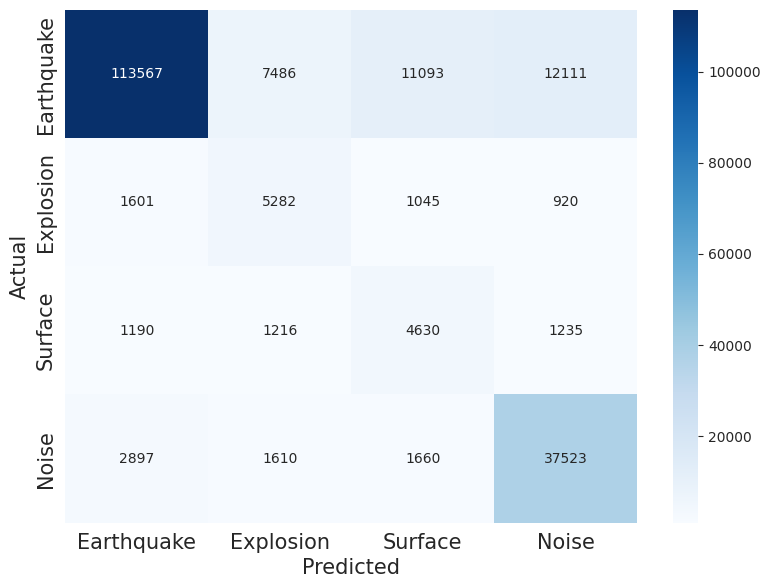

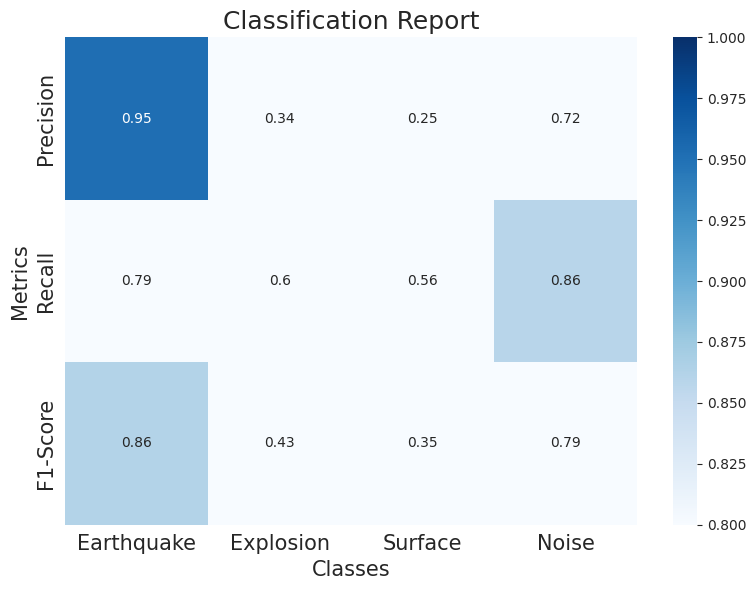

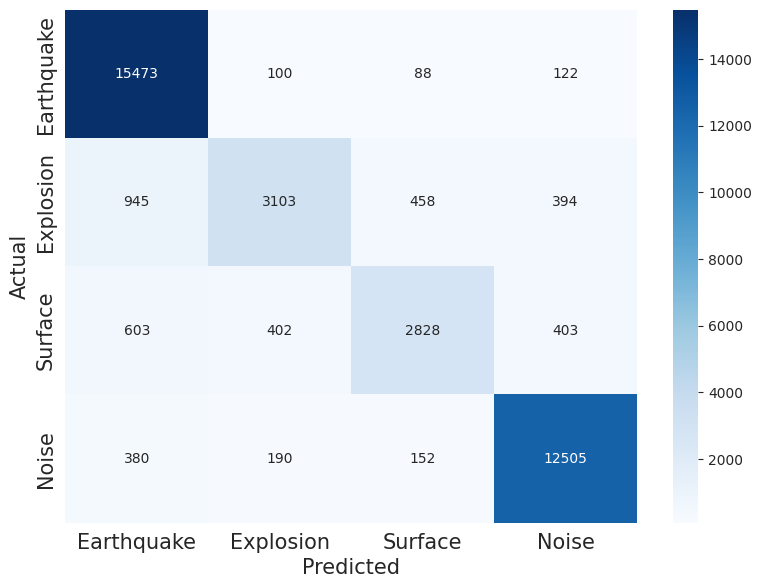

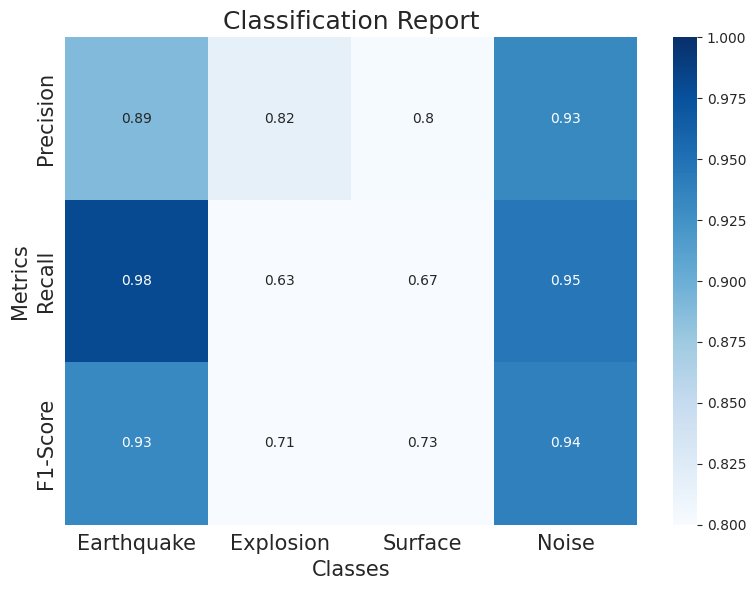

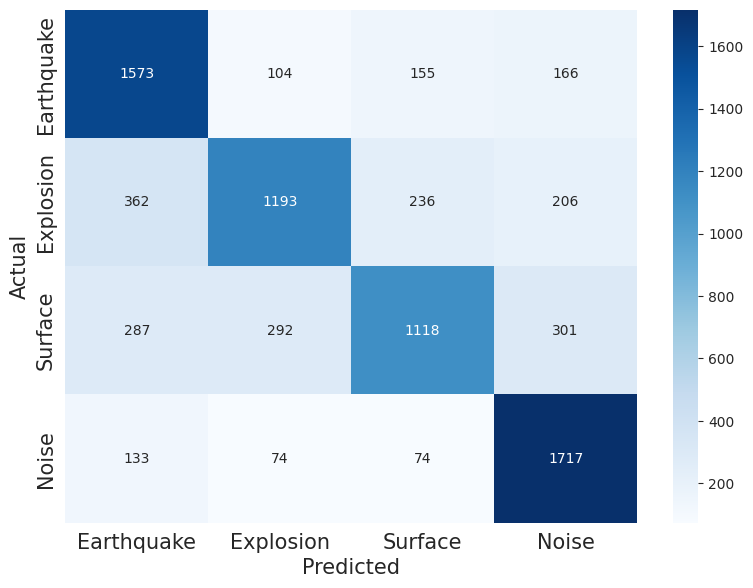

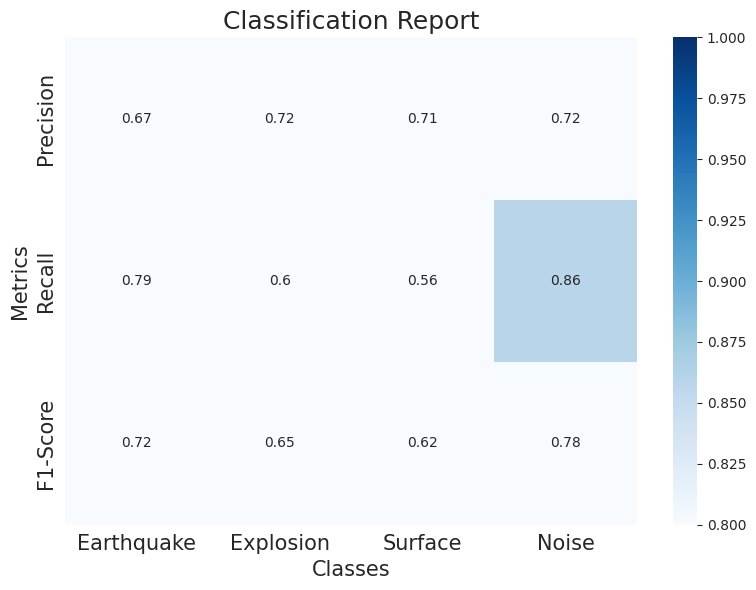

In [217]:
## computing all the results just for physcial features. 
compute_model_performance(x_train = x_train, x_test = x_test, holder = '_scat_')

Fitting the model on 6000 randomly sampled traces per class
computing the models fitting time
Computing the trace wise performance on the global dataset
Computing event wise performance


  0%|          | 0/50 [00:00<?, ?it/s]

Computing the performance on the balanced dataset


100%|██████████| 50/50 [00:57<00:00,  1.15s/it]


Saving results into disk
Saving trained model
saving the scalar params


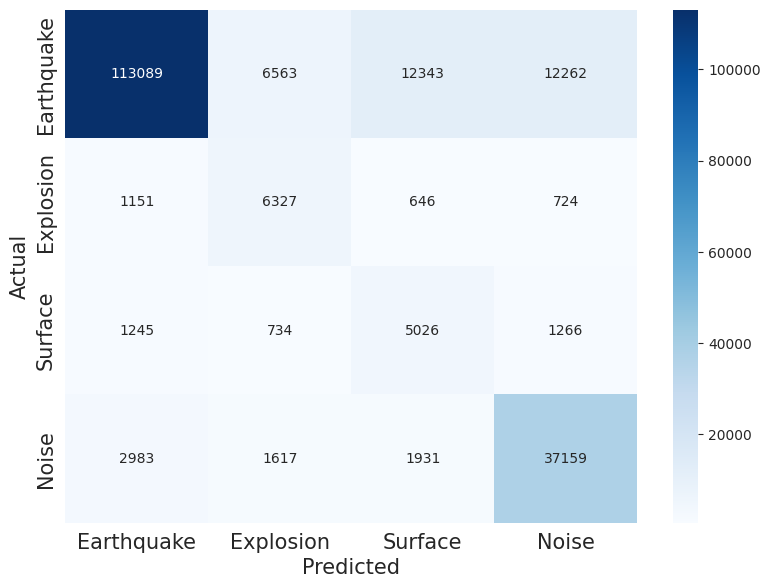

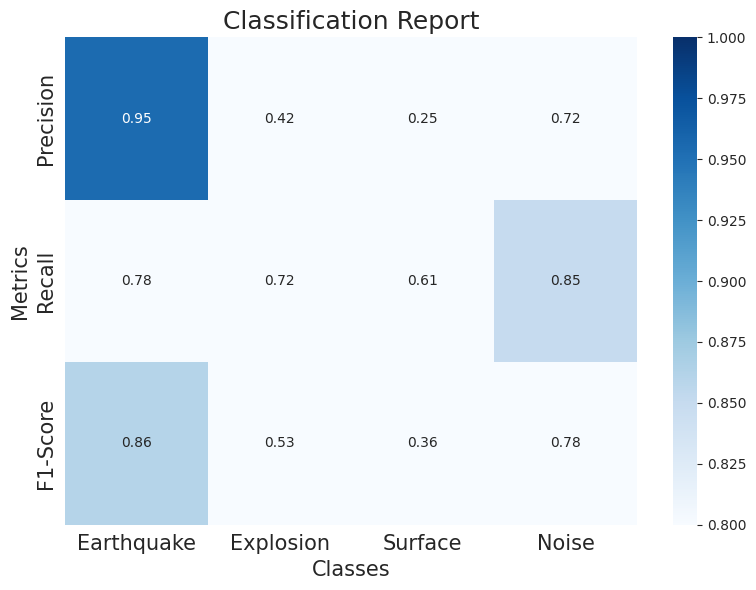

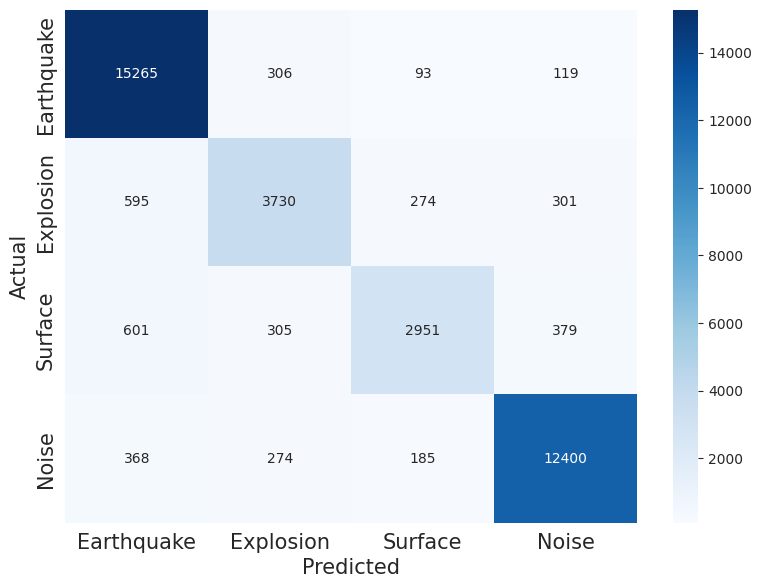

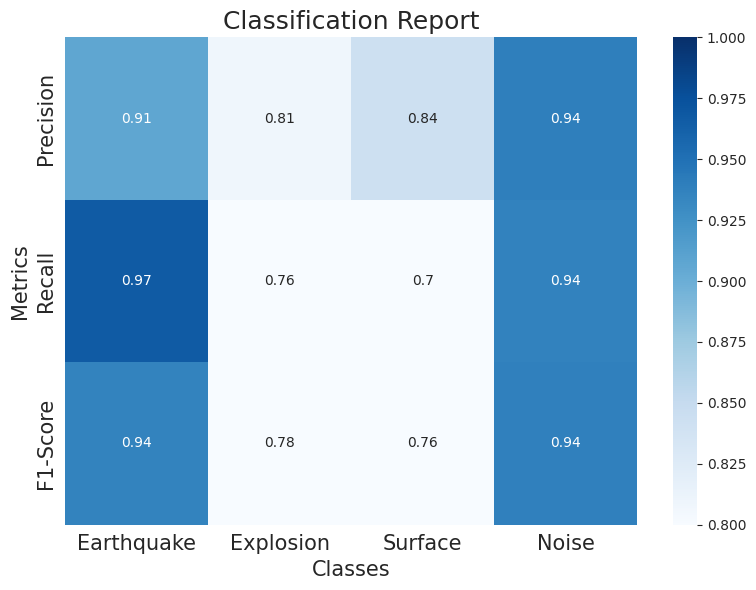

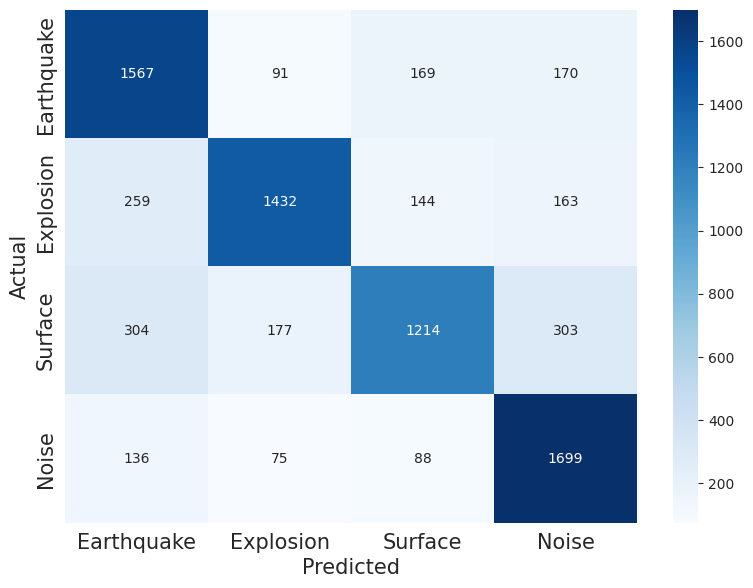

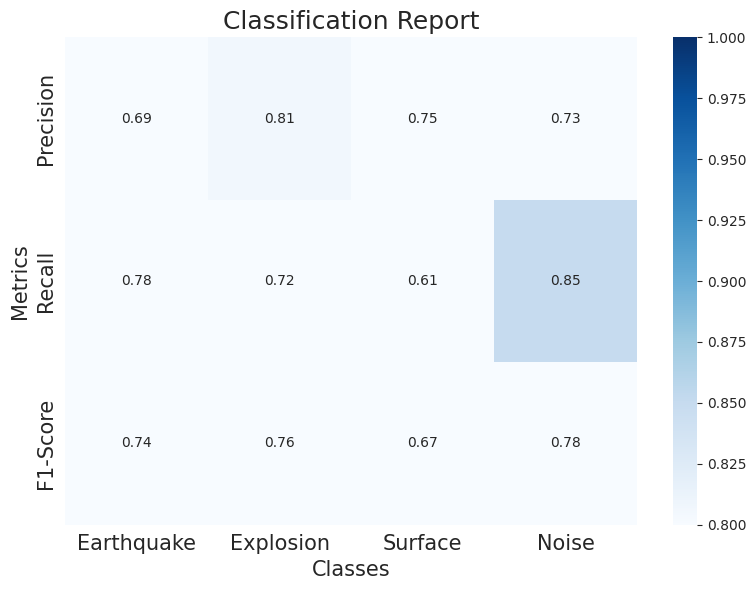

In [218]:
## computing all the results just for physcial features. 
compute_model_performance(x_train = x_train_man, x_test = x_test_man, holder = '_scat_man_')